In [50]:
%matplotlib notebook
import pandas as pd
import os
from sklearn import metrics
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans, MiniBatchKMeans
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import LabelEncoder  
from matplotlib.text import Annotation
import mplcursors

In [44]:
path = '../data/dunnhumby - The Complete Journey CSV'
transaction_df = pd.read_csv(os.path.join(path,"transaction_data.csv"))
product_df = pd.read_csv(os.path.join(path,"product.csv"))
hh_demographic_df = pd.read_csv(os.path.join(path,"hh_demographic.csv"))
bag_of_commodities = pd.read_csv('../data/results/sub_commodity_bag.csv')
hh_demographic_df.head()

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16


In [45]:
# initialize transformer
transformer = TfidfTransformer()
normalized_bag_of_commodities = transformer.fit_transform(bag_of_commodities.fillna(0).values)
normalized_bag_of_commodities

# Take groups arbitrarily
svd = TruncatedSVD(300)
# Max-normalize for k-means
normalizer = Normalizer(copy=False)
#households vs group matrix
households_groups = svd.fit_transform(normalized_bag_of_commodities)
households_groups = normalizer.fit_transform(households_groups)
#groups vs items matrix
groups_items = svd.components_
print(households_groups.shape)

groups_items.shape

(2500, 300)


(300, 2383)

In [46]:
households_groups_filtered = households_groups[:,[0,1,2,4,5,6]]

In [51]:
# Function computes the silhouette score at a given number of clusters and plots it
def find_optimal_kmeans(arr):
  #set n_init to 10 to get more robust results
    km = KMeans(init='k-means++',max_iter=100,n_init=20)
    s_score = []
    for n in range(2,15):
        km.set_params(n_clusters=n)
        km.fit(arr)
        s_score.append(metrics.silhouette_score(arr,km.labels_,sample_size=2500))
    plt.plot(range(2,15),s_score)
    plt.xlabel('n_clusters')
    plt.ylabel('Silhouette Coefficient')
    plt.xticks(range(2,15))
    plt.show()

<IPython.core.display.Javascript object>


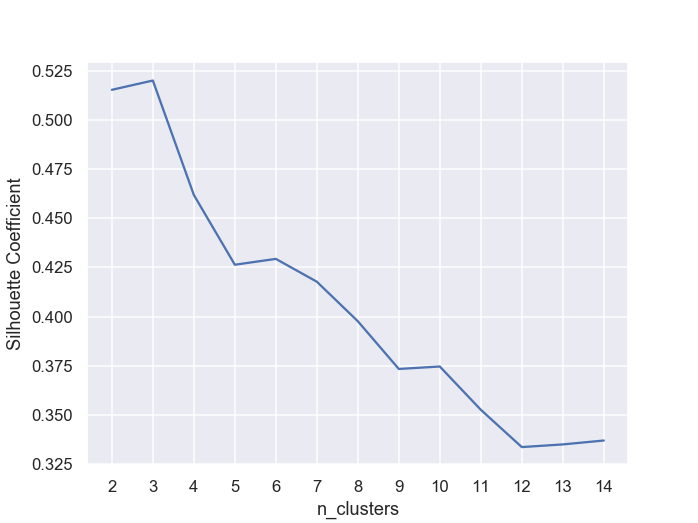

In [52]:
find_optimal_kmeans(households_groups_filtered)

(2500, 6)


<IPython.core.display.Javascript object>


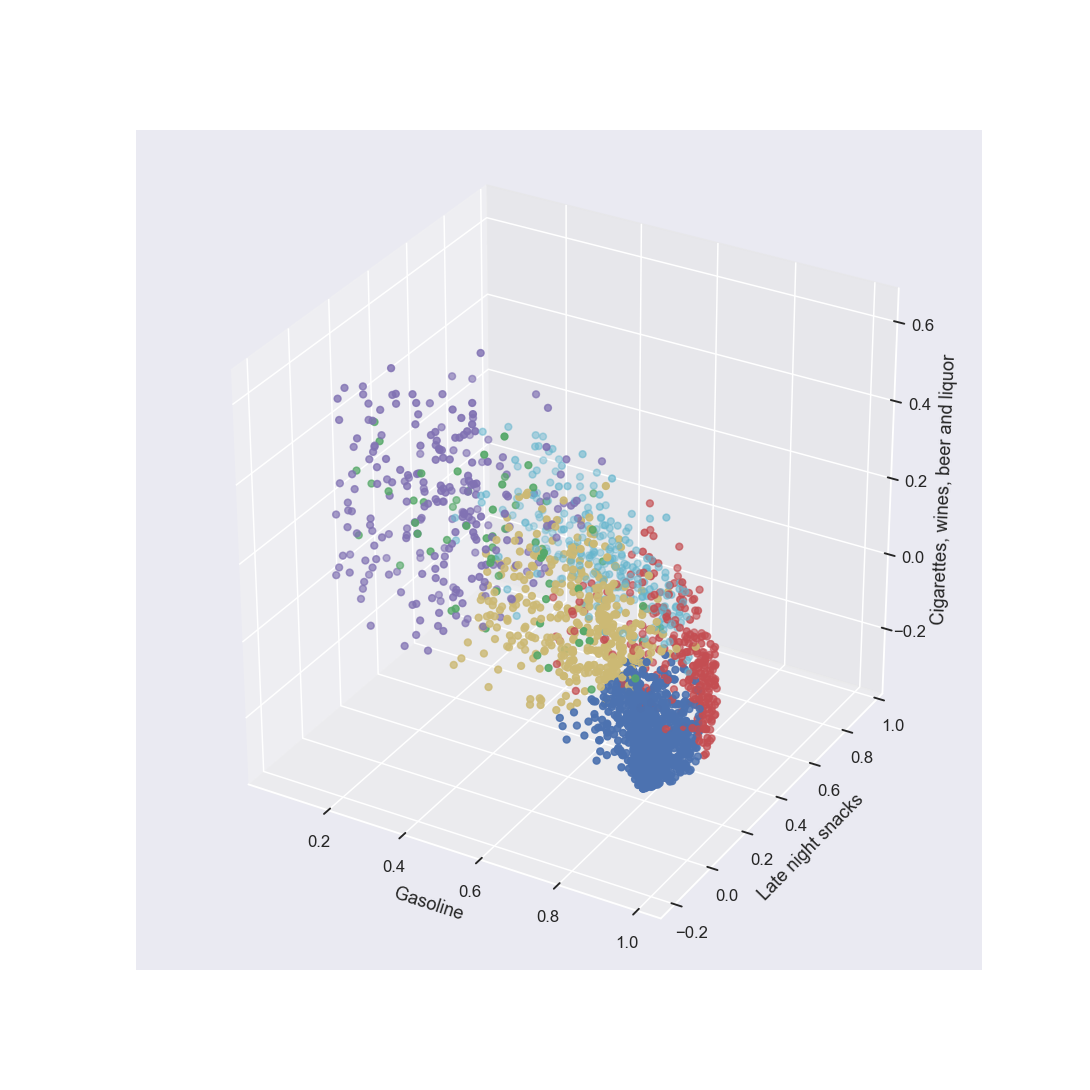

In [89]:
## Visualize Clusters
km = KMeans(n_clusters=6, init='k-means++', max_iter=100, n_init=10)
km.fit(households_groups_filtered)

y_kmeans = km.predict(households_groups_filtered)

print(households_groups_filtered.shape)

colors1 = ['r', 'b', 'g', 'y', 'm', 'c']
fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(households_groups_filtered[:,0],households_groups_filtered[:,1],households_groups_filtered[:,2],c=y_kmeans, cmap=colors.ListedColormap(colors1) )
ax.set_xlabel('Gasoline')
ax.set_ylabel('Late night snacks')
ax.set_zlabel('Cigarettes, wines, beer and liquor')
plt.show()
#based on the 3d plot with the 3 most important groups on the axes, we already clear separations between groups

In [55]:
# Cast and set order
hh_demographic_df['INCOME_DESC'] = hh_demographic_df['INCOME_DESC'].astype('category')
hh_demographic_df.INCOME_DESC = hh_demographic_df.INCOME_DESC.cat.\
                                reorder_categories(['Under 15K', '15-24K','25-34K', '35-49K', '50-74K','75-99K', '100-124K','125-149K','150-174K', '175-199K', '200-249K', '250K+'], ordered=True)
# Cast and set order
hh_demographic_df.KID_CATEGORY_DESC = hh_demographic_df.KID_CATEGORY_DESC.astype('category')
hh_demographic_df.KID_CATEGORY_DESC.cat.reorder_categories(['1', '2', '3+', 'None/Unknown']\
                                                          , ordered=True, inplace=True)
# Casting
hh_demographic_df.HOMEOWNER_DESC = hh_demographic_df.HOMEOWNER_DESC.astype('category')
# Casting
hh_demographic_df.HH_COMP_DESC = hh_demographic_df.HH_COMP_DESC.astype('category')
# Cast and set order
hh_demographic_df.AGE_DESC = hh_demographic_df.AGE_DESC.astype('category')
hh_demographic_df.AGE_DESC.cat\
                    .reorder_categories(['19-24', '25-34', '35-44', '45-54', '55-64', '65+'], ordered=True, inplace=True)
# Cast and set order
hh_demographic_df.HOUSEHOLD_SIZE_DESC = hh_demographic_df.HOUSEHOLD_SIZE_DESC.astype('category')
hh_demographic_df.HOUSEHOLD_SIZE_DESC.cat.reorder_categories(\
                        ['1', '2', '3', '4', '5+'], ordered=True, inplace=True)
# Cast
hh_demographic_df.MARITAL_STATUS_CODE = hh_demographic_df.MARITAL_STATUS_CODE.astype('category')
# Lowercase all column names
hh_demographic_df.columns = map(str.lower, hh_demographic_df.columns)

hh_demographic_df.set_index(hh_demographic_df["household_key"].astype('int64'), inplace=True)
hh_demographic_df = hh_demographic_df.drop(columns=["household_key"])

In [58]:
group_names = ['Gasoline','Late snacks','Cigs & liquor', 'Baby items', 'Dinner', 'Soft drinks']

reduced_df = pd.DataFrame(households_groups_filtered,columns=group_names)
group_appartenance_df = reduced_df.set_index(reduced_df.index.astype('int64'))
group_appartenance_df['group_val'] = group_appartenance_df[group_names].max(axis=1)
group_appartenance_df['group_nb'] = group_appartenance_df[group_names].idxmax(axis=1)
#group_appartenance_df = group_appartenance_df.drop(columns= group_names)
group_appartenance_df.head()

,Gasoline,Late snacks,Cigs & liquor,Baby items,Dinner,Soft drinks,group_val,group_nb
0,0.940250,-0.123886,0.080831,0.015192,-0.047979,-0.031919,0.940250,Gasoline
1,0.942410,-0.069283,0.025845,-0.007200,-0.075220,0.019488,0.942410,Gasoline
2,0.979396,-0.158373,-0.020817,-0.030755,-0.004606,-0.025868,0.979396,Gasoline
3,0.699026,0.334665,-0.053140,-0.102939,0.086710,0.071443,0.699026,Gasoline
4,0.986046,0.045350,-0.045676,0.044345,-0.005107,0.002065,0.986046,Gasoline


In [59]:
group_appartenance_df.groupby('group_nb').count()["Gasoline"]
#unfortunately, the first group comprise almost all the households

group_nb
Baby items         11
Cigs & liquor      87
Dinner             12
Gasoline         2128
Late snacks       257
Soft drinks         5
Name: Gasoline, dtype: int64

In [60]:
#Join w/ demographic info and only select household where demographic info is available
group_appartenance_df.index = group_appartenance_df.index.rename('household_key')
whole_df = group_appartenance_df.join(hh_demographic_df, how='inner')
whole_df.groupby('group_nb').count()['age_desc']
#we will drop the groups with less than 10 memebers because we will not be able to drwa significant conclusions with such low numbers

whole_df = whole_df[whole_df['group_nb'].isin(['Gasoline','Late snacks','Cigs & liquor'])]

In [61]:
age_info = whole_df.groupby(["group_nb"]).age_desc.value_counts()
income_info = whole_df.groupby(["group_nb"]).income_desc.value_counts()
family_size_info = whole_df.groupby(["group_nb"]).household_size_desc.value_counts()

income_info.sort_index()

group_nb       income_desc
Cigs & liquor  15-24K           2
               150-174K         1
               25-34K           3
               35-49K           5
               50-74K           8
               75-99K           1
               Under 15K        3
Gasoline       100-124K        29
               125-149K        34
               15-24K          62
               150-174K        25
               175-199K         9
               200-249K         5
               25-34K          67
               250K+           10
               35-49K         140
               50-74K         167
               75-99K          80
               Under 15K       52
Late snacks    100-124K         5
               125-149K         4
               15-24K          10
               150-174K         4
               175-199K         2
               25-34K           7
               250K+            1
               35-49K          24
               50-74K          16
               75-99K

<IPython.core.display.Javascript object>


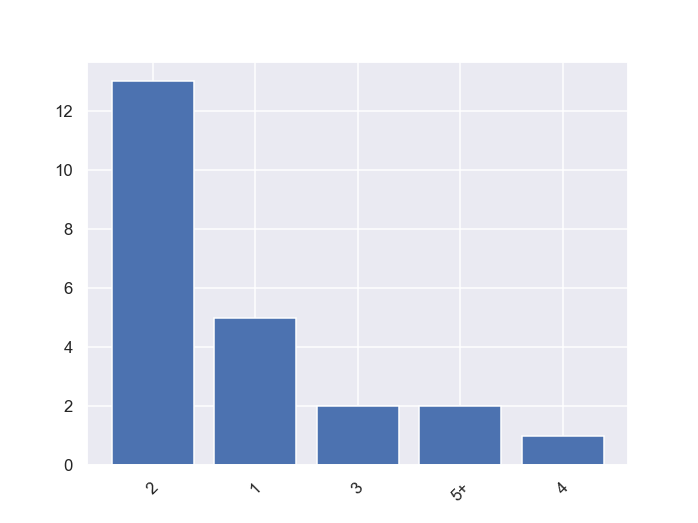

In [68]:
f,a=plt.subplots()
a.bar(family_size_info["Cigs & liquor"].index, family_size_info["Cigs & liquor"].values)
plt.xticks(rotation=45)
plt.show()

In [64]:
group_description_df = pd.DataFrame(index = ['Gasoline','Late snacks','Cigs & liquor'], columns=['age', 'income', 'household_size'])

group_description_df["age"] = age_info.groupby("group_nb").agg('idxmax').apply(lambda x: x[1])
group_description_df["household_size"] = family_size_info.groupby("group_nb").agg('idxmax').apply(lambda x: x[1])
group_description_df["income"] = income_info.groupby("group_nb").agg('idxmax').apply(lambda x: x[1])

group_description_df.head()
#there is no significant differences found between those groups, which suggests that our supermarket is specifically targeted for this demographic

,age,income,household_size
Gasoline,45-54,50-74K,2
Late snacks,45-54,35-49K,2
Cigs & liquor,45-54,50-74K,2


In [83]:
whole_df['income_desc'].unique().categories.values[0]

'Under 15K'

<IPython.core.display.Javascript object>


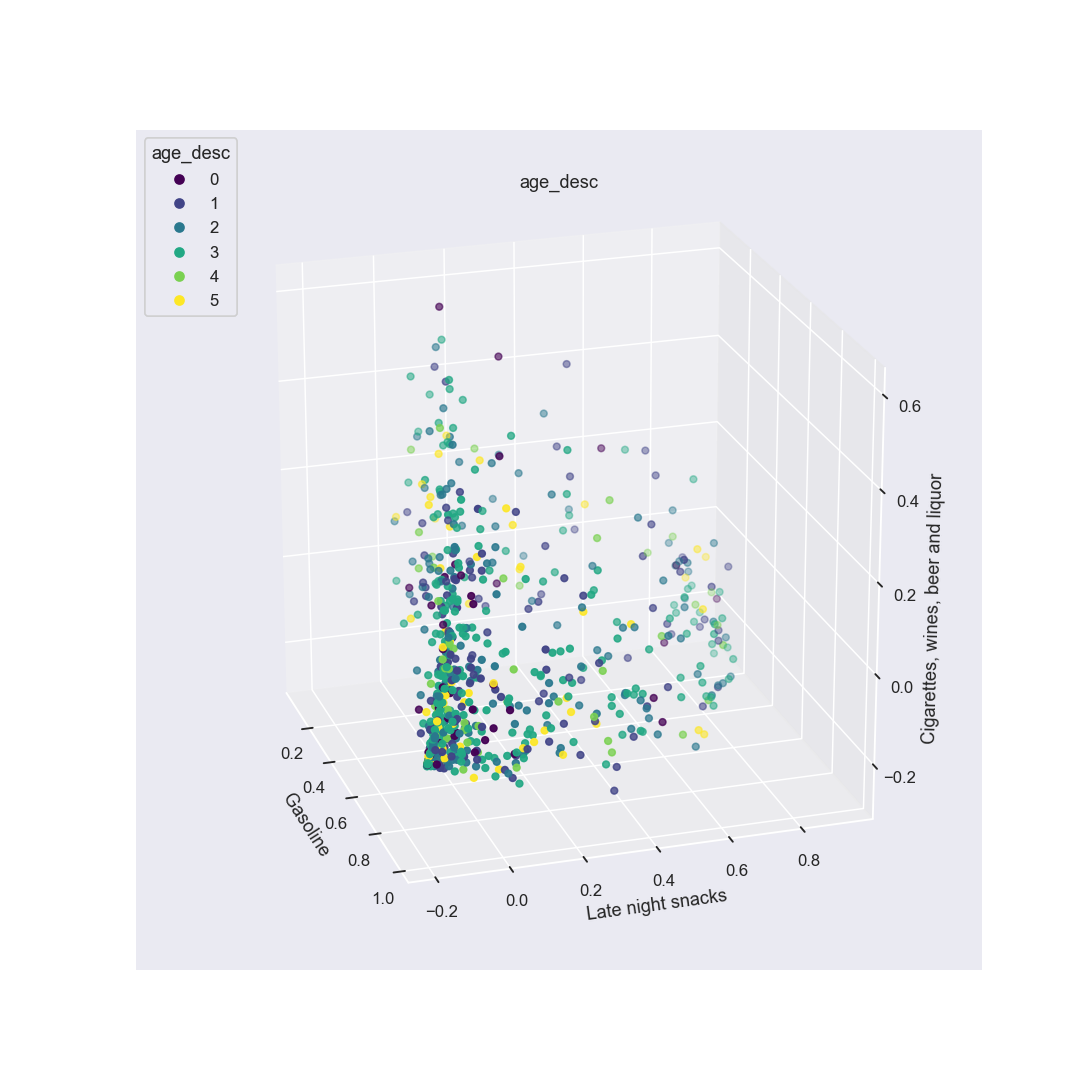

<IPython.core.display.Javascript object>


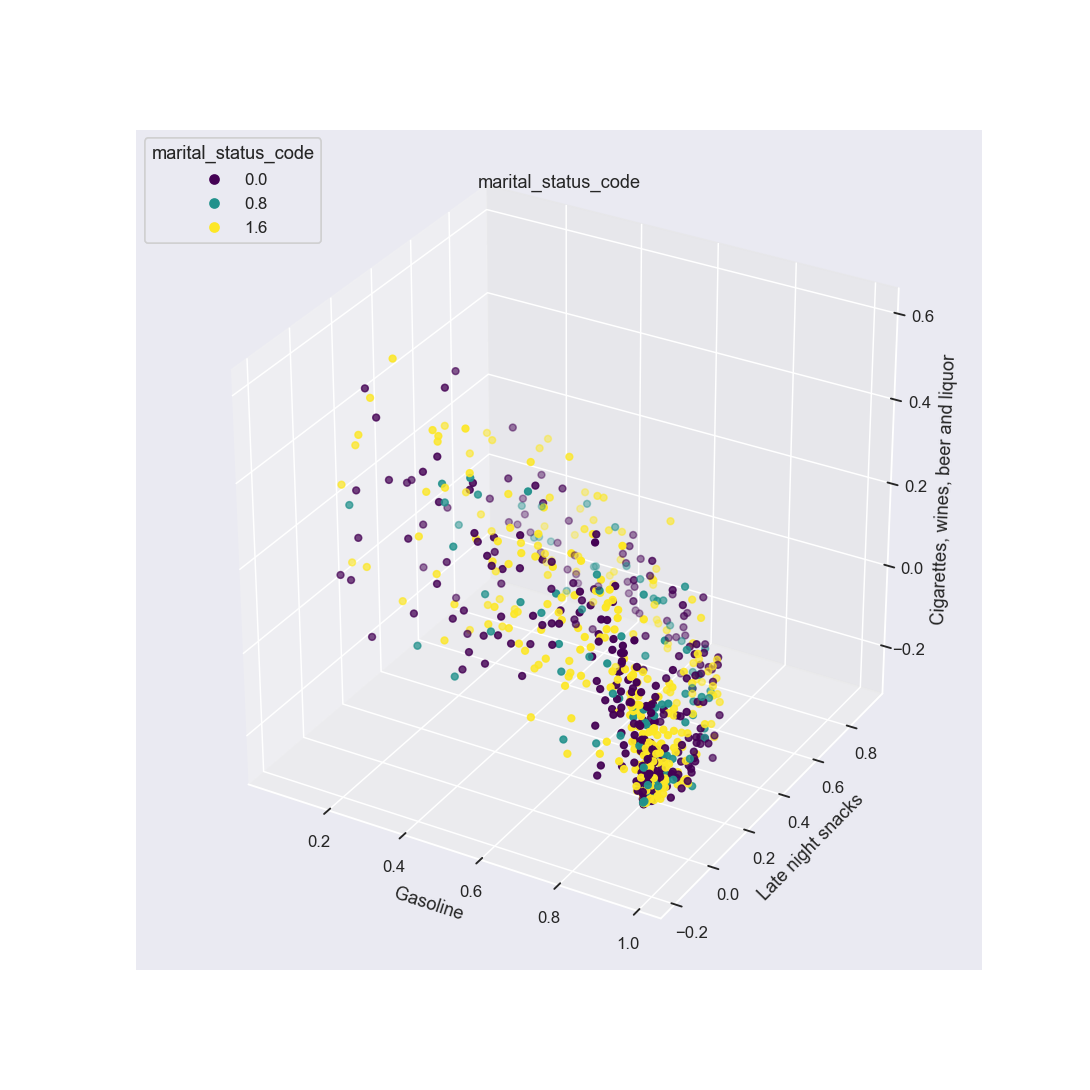

<IPython.core.display.Javascript object>


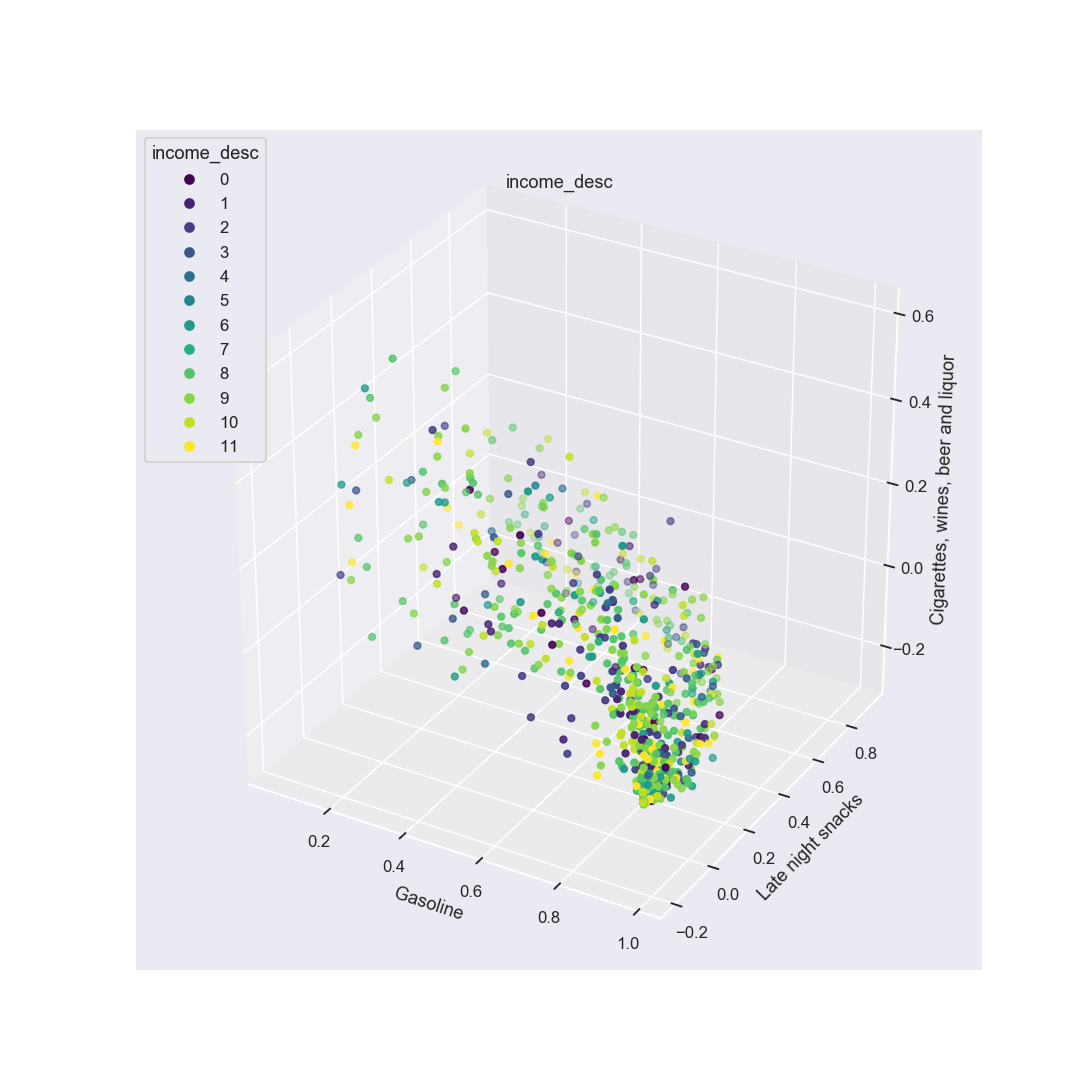

<IPython.core.display.Javascript object>


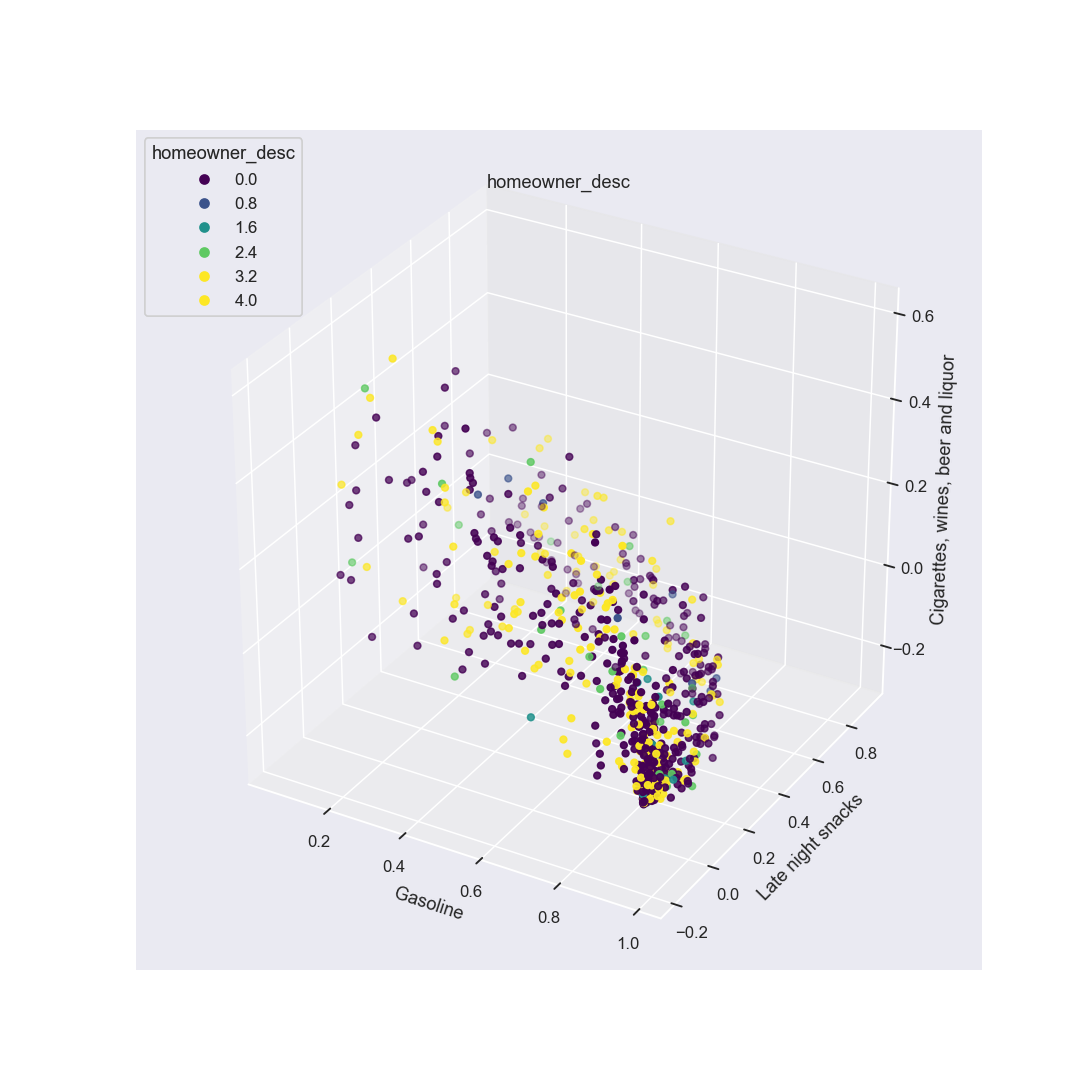

<IPython.core.display.Javascript object>


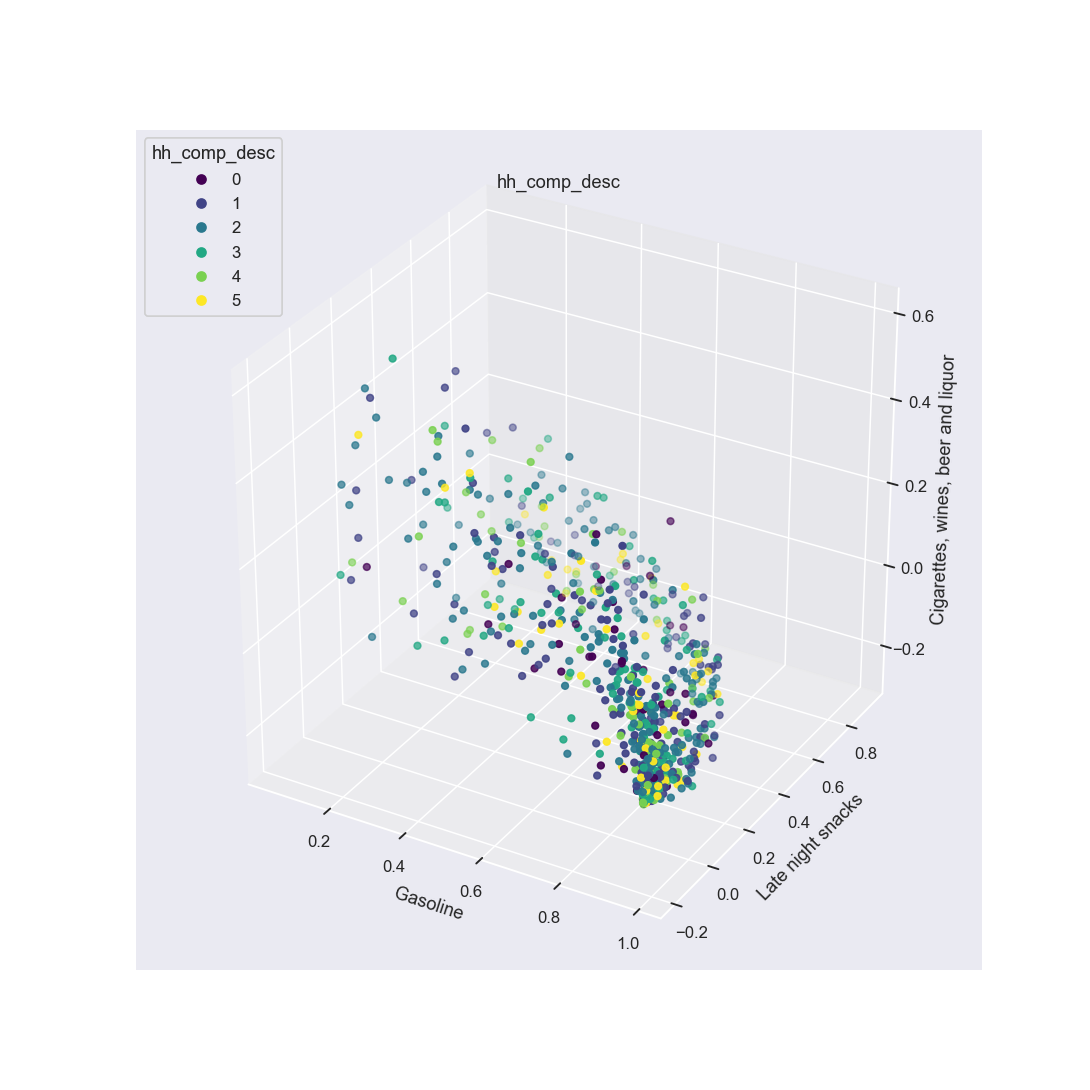

<IPython.core.display.Javascript object>


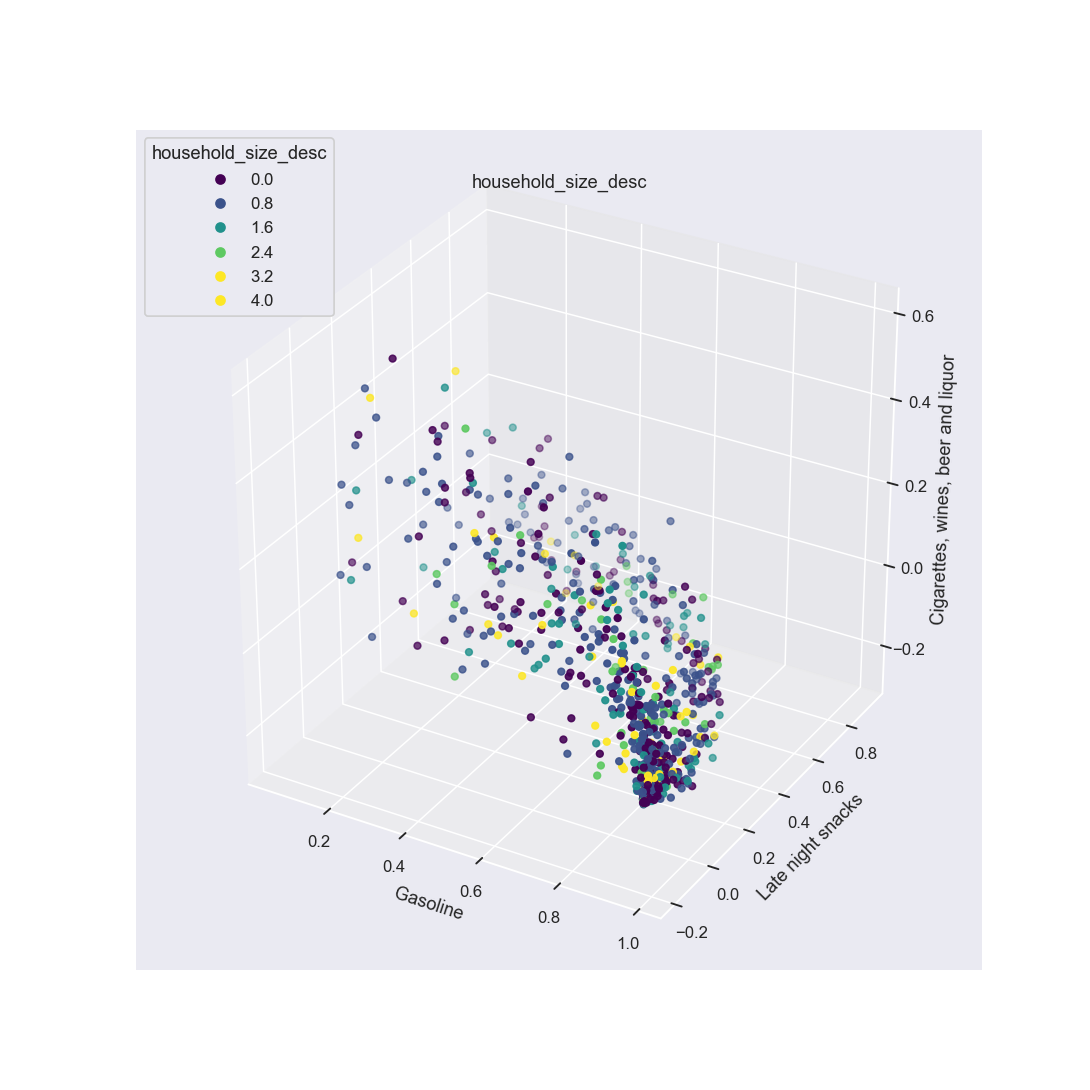

<IPython.core.display.Javascript object>


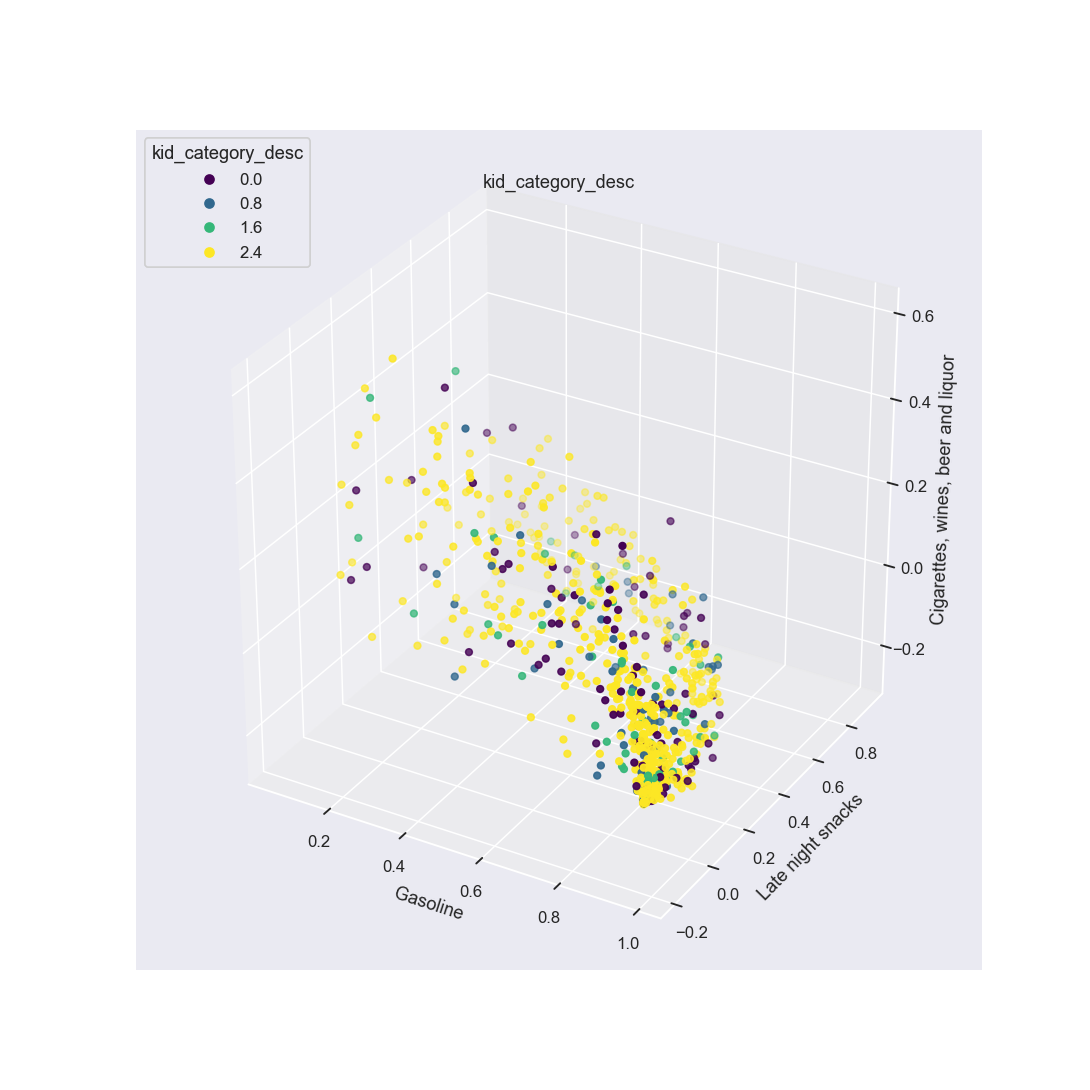

In [88]:
whole_df.head()

list(whole_df['income_desc'].unique().categories.values)

for i in['age_desc','marital_status_code','income_desc','homeowner_desc','hh_comp_desc','household_size_desc','kid_category_desc']: 
    le = LabelEncoder()
    categorical_income = le.fit_transform(whole_df[i])
    #12 income categories 
    viridis = cm.get_cmap('viridis', len(whole_df[i].unique()))
    fig = plt.figure(figsize=[10,10])
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(whole_df['Gasoline'], whole_df['Late snacks'], whole_df['Cigs & liquor'], c=categorical_income, cmap=viridis, label=list(whole_df['income_desc'].unique().categories.values))
    ax.set_title(i)
    ax.set_xlabel('Gasoline')
    ax.set_ylabel('Late night snacks')
    ax.set_zlabel('Cigarettes, wines, beer and liquor')
    #*scatter.legend_elements(num=len(whole_df[i].unique()))
    legend1 = ax.legend(*scatter.legend_elements(num=len(whole_df[i].unique().categories.values)),
                    loc="upper left", title=i)
    ax.add_artist(legend1)

    plt.show()
#based on the 3d plot with the 3 most important groups on the axes, we already clear separations between groups